# Facial Recognition 2: Modeling
This notebook accompanies the book "Programming Applied mathematics for Security" chapter 15: Facial recognition. The code in the cells was used to generate the figures for the second portion of the PoC (see the text for details). This notebook was the development ground for the second portion of the PoC so most of the functions remain unchanged between the two


In [4]:
# -*- coding: utf-8 -*-
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from nominal import associations, correlation_ratio
from random import choice, sample, randint
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
import math
from sklearn.model_selection import train_test_split

Loading the data file from the first portion of the PoC is easy because we saved it in CSV format which can be read directly into a Pandas DataFrame. Working from a DataFrame object isn't strictly necessary, but doing so will make the rest of the modeling tasks much easier. 

It's always a good idea to clean up any unused fields, remove null values using dropna, and then view the basic statistics about the data using the info function.

In [8]:
faces_df = pd.read_csv("facial_geometry.csv")
faces_df

,Unnamed: 0,name,outter_eyes,inner_eyes,right_eye_horz,right_eye_vert,right_ic_nose_top,right_ic_nose_btm,right_oc_nose_btm,left_eye_horz,...,jaw_13_x,jaw_13_y,jaw_14_x,jaw_14_y,jaw_15_x,jaw_15_y,jaw_16_x,jaw_16_y,jaw_17_x,jaw_17_y
0,0,Kevin_Parker,114.271606,50.635956,31.144823,9.055385,24.596748,40.459857,63.505905,32.557641,...,241,242,251,216,253,188,252,160,250,132
1,1,Kevin_Parker,118.511603,51.244512,32.249031,9.055385,24.413111,26.870058,53.160135,35.057096,...,246,242,258,220,263,194,265,168,266,141
2,2,Kevin_Parker,115.572488,49.819675,31.575307,9.219544,24.186773,39.051248,60.926185,34.234486,...,242,245,251,220,254,192,254,164,251,136
3,3,Kevin_Parker,116.103402,52.773099,31.048349,8.246211,23.706539,41.400483,60.415230,32.388269,...,238,232,244,207,245,180,244,155,243,129
4,4,Kevin_Parker,113.951744,49.819675,31.575307,10.198039,23.706539,40.607881,61.741396,32.557641,...,238,238,249,213,251,185,250,157,248,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4103,4103,Joshua_Goodman,102.107786,43.566042,28.071338,11.045361,17.204651,43.081318,58.137767,30.594117,...,243,274,249,252,250,228,249,204,247,180
4104,4104,Joshua_Goodman,67.896981,28.284271,19.416488,7.071068,12.529964,29.966648,39.408121,20.223748,...,197,200,199,186,200,171,200,156,199,141
4105,4105,Joshua_Goodman,100.841460,42.426407,28.284271,10.049876,17.204651,40.853396,54.817880,30.149627,...,228,255,234,234,236,212,235,189,234,166
4106,4106,Joshua_Goodman,98.655968,40.792156,28.284271,10.198039,17.888544,41.593269,57.428216,29.614186,...,149,255,155,235,157,215,156,194,154,173


In [9]:
image_files = faces_df["file"]
faces_df.drop(["Unnamed: 0", "file"], inplace=True, axis=1)
faces_df.dropna(inplace=True, axis=1)
faces_df.replace(np.nan, 0, inplace=True)
faces_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4108 entries, 0 to 4107
Columns: 215 entries, name to jaw_17_y
dtypes: float64(62), int64(152), object(1)
memory usage: 6.7+ MB


We need to manually define a categorical column for the data. I chose to use the fake username assigned to each user to create a category column which is a discrete number that maps to a user's name essentially creating a category index. The general process is to cast the desired field as a category data type, then apply a lambda function to record the category code (which is the index I mentioned).

In [10]:
faces_df["category"] = faces_df["name"].astype("category")
cat_columns = faces_df.select_dtypes(["category"]).columns
faces_df[cat_columns] = faces_df[cat_columns].apply(lambda x: x.cat.codes)
name_map = faces_df[["name", "category"]].set_index(["category"])
faces_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4108 entries, 0 to 4107
Columns: 216 entries, name to category
dtypes: float64(62), int16(1), int64(152), object(1)
memory usage: 6.7+ MB


In [11]:
print("%d people, %d images" % (len(faces_df["name"].unique()), len(faces_df.index)))

223 people, 4108 images


## Creating the true holdout set
We create a 3-image true holdout set, which will not be used for any of the feature selection, model training, or performance estimation. They will be held out until the end to prove the performance. The code below only allows for 1 image from each selected person to be drawn.

In [12]:
real_test = {}
while len(real_test) < 3:
    name = choice(list(faces_df["name"].unique()))
    if name not in real_test.keys():
        group = faces_df[faces_df["name"] == name]
        real_test[name] = choice(group.index.to_list())
index_list = [r[1] for r in real_test.items()]
real_X = faces_df.iloc[index_list]
faces_df.drop(index_list, inplace=True)
real_X

,name,outter_eyes,inner_eyes,right_eye_horz,right_eye_vert,right_ic_nose_top,right_ic_nose_btm,right_oc_nose_btm,left_eye_horz,left_eye_vert,...,jaw_13_y,jaw_14_x,jaw_14_y,jaw_15_x,jaw_15_y,jaw_16_x,jaw_16_y,jaw_17_x,jaw_17_y,category
1165,James_Carter,103.310212,42.190046,32.015621,6.000000,26.570661,40.607881,65.863495,29.154759,7.071068,...,252,226,233,231,212,233,191,235,171,82
219,Gerald_Jimenez,107.004673,44.000000,30.016662,12.041595,21.023796,43.863424,63.126856,33.060551,11.000000,...,275,232,253,236,230,239,206,240,183,66
3572,Lonnie_Wagner,78.313473,32.140317,23.194827,9.055385,17.262677,32.756679,50.606324,23.021729,9.000000,...,206,198,191,203,177,207,161,211,144,138


In [13]:
faces_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4105 entries, 0 to 4107
Columns: 216 entries, name to category
dtypes: float64(62), int16(1), int64(152), object(1)
memory usage: 6.8+ MB


And just to be sure they are actually removed from the data set, w can examine the number of remaining indexes

In [14]:
print("%d people, %d images" % (len(faces_df["name"].unique()), len(faces_df.index)))

223 people, 4105 images


# Feature engineering
The first task in any modeling project is to identify which features in the data contribute the most information to the decision process. We achieve this through a mathematically analyzing the relationships between the values and the predicted value. This process is known as Feature engineering or "Feature Selection" and is a key skill to understand when working with high-dimensional data (see the chapter text for more details).
## Feature Association
The first measure we apply is Feature Association. I am using code from a great blog post on the topic
<a href="https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9">The search for categorical correlation</a>. By default the association function will only display a plot of the results. You can force it to also return the matrix result by setting return_results=True. The function adds annotations to each box unless you tell it not to by setting annot=False. I chose the "Blues reversed" color map to make the gray scale image presented in the text more readable but you can change this to any of the supported <a href="https://matplotlib.org/3.3.2/tutorials/colors/colormaps.html">color maps</a> or <a href="https://matplotlib.org/3.3.2/tutorials/colors/colormap-manipulation.html">define one of your own<a/>.

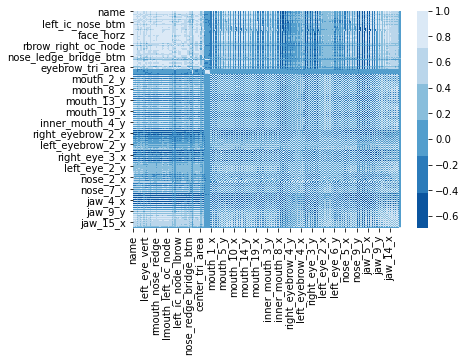

In [15]:
#Using Thiel's U for Nominal-Nominal Associations
assoc_matrix = associations(faces_df, nominal_columns=['name'], theil_u=True, return_results=True,  annot=False, cmap="Blues_r")
#assoc_matrix.to_csv("feature_association.csv")

If you'd like to save the resulting data to a CSV you can uncomment the last line when running the cell above. This can be useful in situations where you have thousands (or more) features to manage.

The next step is to select the subset of attributes that have the highest association with the desired feature. In this case we want to predict the category (name) of the person in a given image, so we are interested in features with a high (>0.95) association to that variable.

In [16]:
assoc_matrix = assoc_matrix[abs(assoc_matrix["name"]) > 0.95]
key_features = list(assoc_matrix["name"].index)[1:]
key_features

['outter_eyes',
 'inner_eyes',
 'right_eye_horz',
 'right_ic_nose_top',
 'right_ic_nose_btm',
 'right_oc_nose_btm',
 'left_eye_horz',
 'nose_horz',
 'nose_vert',
 'chin_lmouth',
 'chin_rmouth',
 'face_horz',
 'face_vert',
 'nose_redge_right_oc_node',
 'nose_ledge_upper_lip_ctr',
 'right_ic_node_rbrow',
 'left_ic_node_lbrow',
 'right_ue_node_rbrow',
 'left_ue_node_lbrow',
 'right_ic_node_bridge_btm',
 'left_ic_node_bridge_btm',
 'right_ic_node_bridge_top',
 'nose_ledge_bridge_btm',
 'nose_redge_bridge_btm',
 'nose_area',
 'chin_tri_area',
 'center_tri_area',
 'eyebrow_tri_area',
 'category']

The association code visualizes the key features, and their relationship to the "name" variable we want to predict, as well as to each other. You can suppress the plot by setting plot=False if you prefer to work with the numeric results only. I also added code to save the figure under a static name which I used to produce the images for the chapter, you can activate this by setting save_plot=True.

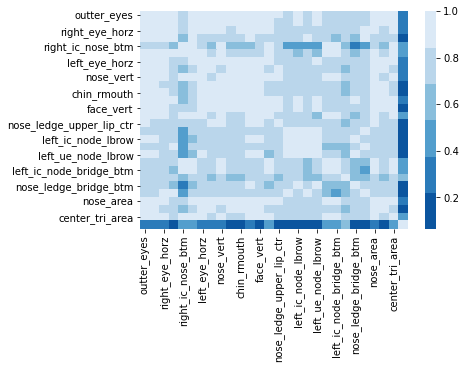

In [17]:
assoc_matrix = associations(faces_df[key_features].drop("category", axis=1), nominal_columns=["name"], annot=False, cmap="Blues_r")

## Mutual Information Classification
The next cell measures "Mutual Information Classification". The scipy implementation uses a nearest-neighbor approach to determine if groups of features can be used to create better neighbor clusters. it does so by training a nearest-neighbor classifier on different subsets of the features and scoring the number of correct classifications. Subsets of features which create better classifiers are considered to be more informative than ones which showed lower classifier performance.

In [18]:

contributing = mutual_info_classif(
        faces_df.drop(["name", "category"], axis=1),
        faces_df["category"],
        discrete_features="auto",
        n_neighbors=7
)

Project the features which have a higher mutual information score into another feature subset named mutual_inf_feats. Take the union of the two feature lists to produce a reduced key feature set that is guaranteed to have highly associated variables which also provide good mutual information.

In [19]:
results = zip(faces_df.drop(["name", "category"], axis=1).columns, contributing)
cutoff = max(contributing) * 0.75
mutual_inf_feats = [f for f,v in results if v >= cutoff]
reduced_features = [k for k in mutual_inf_feats if k in key_features]
print(reduced_features)
print(len(reduced_features))

['outter_eyes', 'inner_eyes', 'right_eye_horz', 'left_eye_horz', 'nose_vert', 'face_horz', 'right_ic_node_bridge_btm', 'left_ic_node_bridge_btm', 'nose_area', 'center_tri_area']
10


## Correlation Ratio
Calculating the correlation ratio (denoted $\eta$) is the last example of feature engineering in the text. This is another function taken from the previously mentioned blog post. See the notes in the nominal.py file for a detailed explanation of how it functions. You probably don't need to include this step. it may even lead to better model performance to skip it. I leave it up to you to experiment with that.

In [20]:
etas = {}
for feat in faces_df.columns.to_list():
    if feat not in ["category", "name"]:
        etas[feat] = correlation_ratio(faces_df[feat], faces_df["category"])
sorted_rank = sorted(etas.items(), key=lambda kv: kv[1])
reduced_key_features = []
for f in sorted_rank[-21:]:
    if f[0] in reduced_features:
        reduced_key_features.append(f[0])
reduced_key_features

['outter_eyes', 'nose_area', 'face_horz', 'center_tri_area']

# Model training
I have opted for the data training split of "Leave one out" which creates a split for each sample. It then uses all the images that are not the split image to train a new classifier and finally uses that classifier to predict the value of the withheld training sample. The LOO algorithm is a specific version of the broader class of cross-validation algorithms which all share the attribute of repeatedly sampling the data then training and testing a classifier on multiple subsets called splits.

In [21]:
X = faces_df[reduced_key_features]
y = faces_df["category"]
loo = LeaveOneOut()
splits = list(loo.split(X))

## Dummy classifiers
The first thing to do when working on classifying data is to define the null performance base line. This is the performance that can be expected by using simple classification rules such as randomly guessing or weighted guessing. Aside from giving a baseline performance to compare results against these classifiers can uncover problems in the data that might impact the reliability of models.
### Uniform Guess classifier
The first dummy classifier uses the random guessing strategy, called uniform-guess classification. In this strategy each class is equally weighted and therefore equally probable. A good performance score from random guessing generally means that there aren't a lot of classes or there is a lack of data. If you imagine flipping a coin and randomly guessing the result you'd expect to be right about 50% of the time on some large number of flips (say 1000) but because of localized clusters in a smaller sample size (say 5 flips) you could conceivably guess 60-80% (3-4) because there are only two classes to choose from and such a small sample size.

In [22]:

dc = DummyClassifier(strategy="uniform")
scores = []
hits = 0
misses = 0
for train_index, test_index in splits:
    X_train, y_train, = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test, = X.iloc[test_index], y.iloc[test_index]  
    cvs = cross_val_score(dc, X_train, y_train)
    score = sum(cvs) / 5
    scores.append(score)
    dc.fit(X_train, y_train)
    y_pred = dc.predict(X_test)
    if y_test.values[0]==y_pred:
        hits += 1
    else:
        misses += 1
print(sum(scores) / len(scores))
print (hits, (hits+misses))
print (hits / (hits+misses))

/home/dreilly/anaconda3/envs/researchenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/dreilly/anaconda3/envs/researchenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/dreilly/anaconda3/envs/researchenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/dreilly/anaconda3/envs/researchenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.004482484582160278
19 4105
0.004628501827040195


Clearly the large number of classes makes random guessing a very bad strategy with a priori odds of 1/221

### Majority class guess
Another strategy which can tell you about the quality of the data sample is to always predict the most represented class in the training set (the majority class). This classifier is good for getting a sense of how heavily weighted towards a single class a data sample is. If this predictor performs well, it means the majority class outweighs the other classes. There are a number of strategies for <a href="https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/">dealing with imbalanced data</a>

In [23]:
dc = DummyClassifier(strategy="most_frequent")
scores = []
hits = 0
misses = 0
for train_index, test_index in splits:
    X_train, y_train, = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test, = X.iloc[test_index], y.iloc[test_index]  
    cvs = cross_val_score(dc, X_train, y_train)
    score = sum(cvs) / 5
    scores.append(score)
    dc.fit(X_train, y_train)
    y_pred = dc.predict(X_test)
    if y_test.values[0]==y_pred:
        hits += 1
    else:
        misses += 1
print(sum(scores) / len(scores))
print (hits, (hits+misses))
print (hits / (hits+misses))

/home/dreilly/anaconda3/envs/researchenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/dreilly/anaconda3/envs/researchenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/dreilly/anaconda3/envs/researchenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/dreilly/anaconda3/envs/researchenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.009744217267525243
40 4105
0.0097442143727162


## Decision Tree classification
Now let's train an actual classifier. One good option for the task at hand is a Decision Tree. By using 5 cross-fold validations (which in this case is 1 fold tested 5 times) we get an average estimated performance for a single image in the set. By taking the average of this average, we get the statistical "Grand mean".

In [24]:
scores = []
tree = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=3)
chose = []
for i in range(50):
    split_i = randint(0, len(splits))
    while split_i in chose:
        split_i = randint(0, len(splits))
    chose.append(split_i)
    train_index, test_index = splits[split_i]
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
    cvs = cross_val_score(tree, X_train, y_train, cv=5)
    score = sum(cvs) / 5
    scores.append(score)
print(sum(scores) / len(scores))

0.6362741986274917


## Random Forest classification
Decision trees alone are sensitive to initial conditions and outlier data. However, by using many decision trees started at different random starting points we can normalize some of this behavior. This normalization often drastically improves the estimated performance

In [25]:
rfc = RandomForestClassifier(n_estimators=100, min_samples_split=5, min_samples_leaf=3)
scores = []
chose = []
hits = 0
misses = 0
for i in range(50):
    split_i = randint(0, len(splits))
    while split_i in chose:
        split_i = randint(0, len(splits))
    chose.append(split_i)
    train_index, test_index = splits[split_i]
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
    cvs = cross_val_score(rfc, X_train, y_train, cv=5)
    score = sum(cvs) / 5
    scores.append(score)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    if y_test.values[0]==y_pred:
        hits += 1
    else:
        misses += 1
print(sum(scores) / len(scores))
print (hits, (hits+misses))
print (hits / (hits+misses))

0.7620223225691453
34 50
0.68


# Verifying the model
Now we have an estimated performance for how our classifier should do on a never-before-seen data sample. To test this hypothesis we use the hold-out data of 3 test images defined in the beginning. The objective is to predict the category which maps to the proper user name.

In [26]:
real_y = real_X["category"]
test_X = real_X[reduced_key_features]
rfc = RandomForestClassifier(n_estimators=100, min_samples_split=5, min_samples_leaf=3)
rfc.fit(X, y)
y_pred = rfc.predict(test_X)
print(list(zip(y_pred, real_y)))

[(82, 82), (2, 66), (138, 138)]


Rather than predicting the single class you can get 'probability' estimates (which aren't necessarily exact probabilities). The result is a list of lists, one for each sample in the test set. Each list contains $n$ values indexed off of the corresponding class identifier. So for example the 0th element holds the probability score for the class with ID 0, the 4th cell contains the probability for the class with ID 4 and so on.

In [27]:
y_prob = rfc.predict_proba(test_X)
y_prob

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.0025    , 0.        ,
        0.00142857, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

Something should jump out at you immediately, there shouldn't be any 0s in real probabilities! A zero or one can only occur in probability after an event has happened or after the true outcome is known. Rather than being real probabilities these can be viewed as probability weights which the algorithm assigns to each class based on how likely the algorithm feels a sample belongs to a certain class. A weight of 0 in this sense indicates the algorithm believes strongly the sample couldn't belong to that class

## Confidence threshold
Setting a minimum confidence threshold to accept a prediction as valid is an important step. There are several ways you can settle on a good threshold. 
First, examine the histogram of weights for each sample by plotting the results using the hist function.
Here I use 3 subplots with a sared y axis so all three are directly comparable. I also use the tight_layout function to automatically space the plots to avoid overlapping.

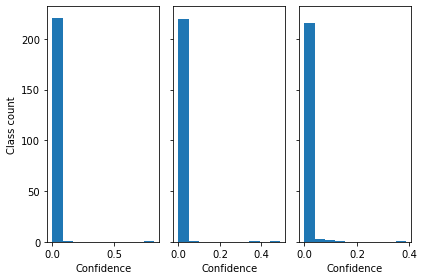

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)
ax[0].set_ylabel("Class count")
ax[0].set_xlabel("Confidence")
ax[1].set_xlabel("Confidence")
ax[2].set_xlabel("Confidence")
ax[0].hist(y_prob[0])
ax[1].hist(y_prob[1])
ax[2].hist(y_prob[2])
fig.tight_layout()
plt.show()

You can see the large majority of classes get 0.0 weight with only a few classes getting any weight at all, and one class getting the majority of the weight. Examining the plots, it appears we can set a confidence threshold somewhere around 0.30-0.35 and all the correct classifications would be kept while all the incorrect classes fall below this line. 

### A priori probability weight
Including an estimate for the average weight is useful to show the base score each class would get, assuming they were all equally weighted. As you can see the predicted classes were all weighted extremely high compared to the average weight of all the non-zero classes. All the weights sum up to one so it is easy enough to calculate the a priori weight, assuming all the classes were to be weighted as equally probable, by dividing $\frac{1.0}{n} $ where$\ n $ is the number of classes in the data.

In [29]:
print("average weight: %.4f" % (1.0 / len(y_prob[0])))

average weight: 0.0045


The more confident the algorithm is, the higher the probability weight will be compared to this naive assumption. In the histogram plots we saw that 0.3-0.35 might make a good threshold. The lower bound of this  is more than 66 times the a priori weight with the upper bound being more than 77 times.

### Confidence distribution
Another approach is to compare the probability weight against the average score from only the classes which had a non-zero weight. This is similar to the previous measure in that we are dividing $\frac{1.0}{n} $ but $\ n $ is now the number of classes with non-zero weight.

In [30]:
nzc_set = []
for pred_list in list(y_prob):
    non_zero_classes = []
    for i in range(0, len(pred_list)):
        if pred_list[i] > 0:
            non_zero_classes.append((i, pred_list[i]))
    print("Non-zero class count: %d" % len(non_zero_classes))
    nzc_avg = 1.0/len(non_zero_classes)
    print("Adjusted average: %.4f" % nzc_avg)
    nzc_set.append(non_zero_classes)

Non-zero class count: 8
Adjusted average: 0.1250
Non-zero class count: 11
Adjusted average: 0.0909
Non-zero class count: 25
Adjusted average: 0.0400


You can see that adjusting the number of classes before averaging the weights has a drastic impact but the numbers are more realistic than the a priori measure because this looks at only the distribution among classes the algorithm. The lower the adjusted average, the higher the number of classes the algorithm thought were possible.

The next cell loops over all of the predictions to find the highest weighted class in each and compares that against the threshold 0.35 

In [31]:
thresh = 0.35
pred_probs = []
print("average weight: %.4f" % (1.0 / len(y_prob[0])))
for pred_list in list(y_prob):
    confidence = 0
    max_i = -1
    for i in range(0, len(pred_list)):
        if pred_list[i] > confidence:
            confidence = pred_list[i]
            max_i = i
    pred_probs.append((max_i, confidence, confidence > thresh))
pred_probs

average weight: 0.0045


[(82, 0.8246727994227995, True),
 (2, 0.4888091630591631, True),
 (138, 0.38649314574314575, True)]

Of course, this method works better if you examine the weight variance among correct and incorrectly classified instance confidences. You can do this by using predict_proba when training the model on the initial data.

In [33]:
X = faces_df[reduced_key_features]
y = faces_df["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
rfc = RandomForestClassifier(n_estimators=100, min_samples_split=5, min_samples_leaf=3)
rfc.fit(X_train, y_train)
y_prob = rfc.predict_proba(X_test)
pred_probs = []
non_zero_confs = []
for i in range(len(list(y_prob))):
    pred_list = y_prob[i]
    confidence = 0
    max_i = -1
    for j in range(0, len(pred_list)):
        if pred_list[j] > 0:
            non_zero_confs.append(pred_list[j])
        if pred_list[j] > confidence:
            confidence = pred_list[j]
            max_i = j
    pred_probs.append({
        "predicted": max_i,
        "confidence": confidence,
        "correct": max_i == list(y_test)[i]
    })

prob_df = pd.DataFrame(pred_probs)
prob_df["above"] = prob_df["confidence"].apply(lambda x: x>0.35)
prob_df

,predicted,confidence,correct,above
0,179,0.633147,True,True
1,215,0.239567,False,False
2,70,0.576778,False,True
3,81,0.560674,True,True
4,85,0.663302,True,True
...,...,...,...,...
406,30,0.890333,True,True
407,152,0.278409,False,False
408,204,0.836460,True,True
409,164,0.474944,True,True


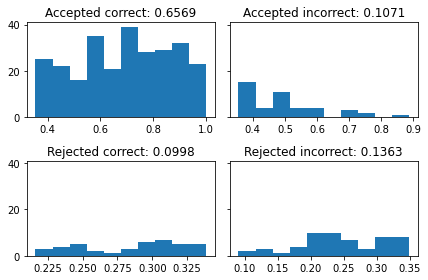

In [34]:
accepted_positives = prob_df[(prob_df["correct"] == True) & (prob_df["above"] == True)]
accepted_negatives = prob_df[(prob_df["correct"] == False) & (prob_df["above"] == True)]
rejected_positives = prob_df[(prob_df["correct"] == True) & (prob_df["above"] == False)]
rejected_negatives = prob_df[(prob_df["correct"] == False) & (prob_df["above"] == False)]
fig, ax = plt.subplots(nrows=2,ncols=2,sharey=True)
ax[0][0].hist(accepted_positives["confidence"])
ax[0][0].set_title("Accepted correct: %.4f" % (len(list(accepted_positives.index))/len(list(prob_df.index))))
ax[0][1].hist(accepted_negatives["confidence"])
ax[0][1].set_title("Accepted incorrect: %.4f" % (len(list(accepted_negatives.index))/len(list(prob_df.index))))
ax[1][0].hist(rejected_positives["confidence"])
ax[1][0].set_title("Rejected correct: %.4f" % (len(list(rejected_positives.index))/len(list(prob_df.index))))
ax[1][1].hist(rejected_negatives["confidence"])
ax[1][1].set_title("Rejected incorrect: %.4f" % (len(list(rejected_negatives.index))/len(list(prob_df.index))))
plt.title == "Confidence distributions"
plt.tight_layout()
plt.show()

Accepted correct represents rows which the algorithm predicted correctly and had a high enough confidence to meet the threshold set. Accepted incorrect are the samples which the algorithm go wrong but was confident enough in it's prediction to meet the threshold. These are the ones we want to minimize as much as possible. Rejected correct are samples which the algorithm predicted correctly but was not confident enough in to meet the threshold. Finally rejected incorrect are rows that the algorithm incorrectly predicted but was not confident in the incorrect decision. It's a good thing for incorrect predictions to have a low weight so they get dismissed.The performance of the threshold can be seen as the combination of the accepted correct and the rejected incorrect rows. In this case close to 79% of the test data was correctly handled by the threshold

# Automated Parameter selection
The next cell shows how to automatically find the best configuration from a list of potential configurations for a classifier using the GridSearchCV class. You define a list of classifiers and parameter values to test in a dictionary.

In [35]:
from sklearn.model_selection import GridSearchCV
n_estimators = [x for x in range(20, 150, 20)] # Trees in the forest
max_depth = [x for x in range(10, 110, 11)] # Max levels in any tree
max_depth.append(None)
min_split = [2, 5, 10] # Min samples required to consider a split
min_leaf = [1, 2, 3] # Min samples required to consider a leaf
bootstrap = [True, False] # whether or not to randomize samples
params_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_split,
               'min_samples_leaf': min_leaf,
               'bootstrap': bootstrap}
print(params_grid)
lens = [len(v) for k,v in params_grid.items()]
tot = lens[0]
# You can manualy calculate the number of training cycles
# by multiplying the lengths of each parameter list
# then multiplying that by the number of cross-folds
for v in lens[1:]:
    tot = tot*v
print("%d classifiers" % tot)
print("%d trainings" % (tot*5))

{'n_estimators': [20, 40, 60, 80, 100, 120, 140], 'max_depth': [10, 21, 32, 43, 54, 65, 76, 87, 98, 109, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3], 'bootstrap': [True, False]}
1386 classifiers
6930 trainings


You then fit the GridSearch object the way you would any normal classifier. The difference is the GridSearchCV algorithm creates a classifier of the type you define for each possible combination of parameters from the parameter grid and runs cross-fold (default 5-fold) validation on each. 

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
rfc = RandomForestClassifier()
grid_search = GridSearchCV(
    estimator=rfc, 
    param_grid=params_grid,
    verbose=2,
    n_jobs = -1,
    refit=False
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1386 candidates, totalling 6930 fits


/home/dreilly/anaconda3/envs/researchenv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 21, 32, 43, 54, 65, 76, 87, 98, 109,
                                       None],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [20, 40, 60, 80, 100, 120, 140]},
             refit=False, verbose=2)

After the jobs finish (which can take a long time depending on how many processing cores your machine has) you can print the best settings found from all the combinations.

In [109]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 76,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

You can also print the score for the best classifier

In [110]:
grid_search.best_score_

0.7849148160758648

A somewhat faster, but less thorough, way is to use RandomizedSearchCV instead. The basic idea is the same, except that random search creates a fixed number of classifiers $ (n\_iter * cv) $ with parameters randomly selected from the set of possible options. 

In [113]:
from sklearn.model_selection import RandomizedSearchCV
rfc = RandomForestClassifier()
rf_search = RandomizedSearchCV(
    estimator = rfc, 
    param_distributions = params_grid,
    n_iter = 50,
    cv = 5,
    verbose=2,
    random_state=42,
    n_jobs = -1
)
rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.9min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 21, 32, 43, 54, 65,
                                                      76, 87, 98, 109, None],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 40, 60, 80, 100,
                                                         120, 140]},
                   random_state=42, verbose=2)

In [115]:
rf_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 21,
 'bootstrap': True}

In [116]:
rf_search.best_score_

0.7647183539279142